In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt



In [2]:
class haltCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('loss') <= 0.0005):
            self.model.stop_training = True

In [3]:

def create_df(file):
    df = pd.read_csv(file,)
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
    df.set_index('Date', inplace=True)
    return df

def segment_df(df, start_date: str, end_date: str):        
    data = df.loc[start_date:end_date]
    return data    


def resample_data(df, size: str):               # size will will specify weekly or monthly
    data = df.resample(size).agg({'Sales':'sum', 'Dollar to Pkr':'mean', 'Daily Cases':'sum'})
    return data

def resample_stock_data(df: pd.DataFrame):
    
    df_temp = df.copy(deep=True)

    df_temp.drop('Sales', inplace=True, axis=1)

    df_temp.drop('Average Discount', inplace=True, axis=1)
    df_temp.drop('Day', inplace=True, axis=1)
    df_temp.drop('Week Day', inplace=True, axis=1)
    df_temp.drop('Week End', inplace=True, axis=1)
    df_temp.drop('Hijri Dates', inplace=True, axis=1)

    # df_temp['Date'] = pd.to_datetime(df_temp['Date'], format="%Y-%m-%d")
    # df_temp.set_index('Date', inplace=True)
    df_temp = df_temp.resample('M').sum()

    for index, row in df_temp.iterrows():
        df_temp.loc[index, 'Year'] = index.year
        df_temp.loc[index, 'Month'] = index.month
        df_temp.loc[index, 'eid ul fitr'] = row['eid ul fitr']/30
        df_temp.loc[index, 'eid ul Adha'] = row['eid ul Adha']/30
        df_temp.loc[index, 'Muharrum'] = row['Muharrum']/30
        df_temp.loc[index, 'Wheat Harvest'] = row['Wheat Harvest']/30
        df_temp.loc[index, 'Cotton Harvest'] = row['Cotton Harvest']/30

    return df_temp

def moving_average(df, window_size, column_name, new_column_name):
    data = df
    data[new_column_name] = data[column_name].rolling(window=window_size).mean()
    return data

def view_df(df, head: bool=False, tail: bool=False):
    if head == False and tail == False:
        print(df)
    elif head == True:
        print(df.head(10))
    else:
        print(df.tail(10))

def line_plot(df, columns: list, color):
    for c in columns:
        plt.plot(df.index, df[c], color = color)
        plt.scatter(df.index, df[c], color = color)
        plt.show()

def replace_missing(df):
    data = df
    for column in data:
        data[column].interpolate(inplace = True)
    return data

def train_test_split(df, split):
    train_size = int(len(df)*split)
    train_dataset, test_dataset = df.iloc[:train_size],df.iloc[train_size:]
    return train_dataset, test_dataset

def create_X_Y_train(training_df, testing_df, target_variable):
    X_train = training_df.drop(target_variable, axis = 1)
    y_train = training_df.loc[:,target_variable]
    
    X_test = testing_df.drop(target_variable, axis = 1)
    y_test = testing_df.loc[:,target_variable]

    return X_train, y_train, X_test, y_test

def scale_and_transform(x_train, y_train, x_test, y_test):
    scaler_x = MinMaxScaler(feature_range = (0,1))
    scaler_y = MinMaxScaler(feature_range = (0,1))
    input_scaler = scaler_x.fit(x_train)
    output_scaler = scaler_y.fit(y_train)
    train_y_norm = output_scaler.transform(y_train)
    train_x_norm = input_scaler.transform(x_train)
    test_y_norm = output_scaler.transform(y_test)
    test_x_norm = input_scaler.transform(x_test)

    return scaler_x, scaler_y, train_x_norm, train_y_norm, test_x_norm, test_y_norm

def create_dataset (x_norm, y_norm, time_steps = 1):
    Xs, ys = [], []
    for i in range(len(x_norm)-time_steps):
        v = x_norm[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y_norm[i+time_steps])
    return np.array(Xs), np.array(ys)

def create_model_bilstm(units, loss, x_train, target_size):
    model = Sequential()
    model.add(Bidirectional(LSTM(units = units,                             
              return_sequences=True),
              input_shape=(x_train.shape[1], x_train.shape[2])))
    # model.add(Bidirectional(LSTM(units = units, return_sequences = True)))
    # model.add(Bidirectional(LSTM(units = units, return_sequences = True)))
    # model.add(Bidirectional(LSTM(units = units, return_sequences = True)))
    model.add(Bidirectional(LSTM(units = units, return_sequences = True)))
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(target_size))
    #Compile model
    cosine_loss = tf.keras.losses.CosineSimilarity(axis=1)
    logcosh = tf.keras.losses.LogCosh()
    model.compile(loss=loss, optimizer='adam')
    return model

def create_model(model_name, units, loss, x_train, target_size):
    model = Sequential()
    model.add(model_name (units = units, return_sequences = True,
                input_shape = [x_train.shape[1], x_train.shape[2]]))
    model.add(Dropout(0.2))
    model.add(model_name (units = units, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(model_name (units = units, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(model_name (units = units, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(model_name (units = units, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(model_name (units = units))
    model.add(Dropout(0.2))
    model.add(Dense(units = target_size))
    cosine_loss = tf.keras.losses.CosineSimilarity(axis=1)
    logcosh = tf.keras.losses.LogCosh()
    #Compile model
    model.compile(loss=loss, optimizer='adam')
    return model


def fit_model(model, epochs, x_train, y_train):
    trainingStopCallback = haltCallback()
    # early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
    #                                            patience = 10)
    history = model.fit(x_train, y_train, epochs = epochs,  
                        validation_split = 0.2, batch_size = 32, 
                        shuffle = False,callbacks = trainingStopCallback
                        )
    return history

def plot_loss (history, name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    plt.title(name)
    filename = 'loss ' + name
    plt.savefig(filename)
    # plt.show()

def inverse_transformation(scaler_y, y_train:np.ndarray, y_test:np.ndarray):
    y_test = scaler_y.inverse_transform(y_test)
    y_train = scaler_y.inverse_transform(y_train)
    return y_train, y_test

def model_fitting(model, x_train, scaler_y):

    fitting = model.predict(x_train)
    return scaler_y.inverse_transform(fitting)

def plot_fit(fit, y_train, name, column_name, epochs):
    plt.figure(figsize=(10, 6))
    range_future = len(fit)
    plt.plot(np.arange(range_future), np.array(y_train), 
             label='Training Data')     
    plt.plot(np.arange(range_future),np.array(fit),
            label='Model Fit ' + name)
    plt.legend(loc='upper left')
    plt.xlabel('Time')
    plt.ylabel('Sales')
    plt.title(column_name)
    filename = column_name + ' model fitting ' + str(epochs)
    # plt.savefig(filename)
    plt.show()

def prediction(model, x_test, scaler_y):
    prediction = model.predict(x_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction

def plot_future(prediction, y_test, name, column_name, epochs):
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), 
             label='Test Data')     
    plt.plot(np.arange(range_future),np.array(prediction),
            label='Prediction ' + name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (week)')
    plt.ylabel('Sales')
    plt.title(column_name)
    filename = column_name + ' prediction ' + str(epochs)
    # plt.savefig(filename)
    plt.show()

def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')


In [4]:
file = 'Working Data\Stocks\category r179f-fix with features.csv'
data = create_df(file)
data = segment_df(data, '2017-04-01','2021-12-01')
view_df(data)    

            Sales  Average Discount  Year  Month  Day  Week Day  Week End  \
Date                                                                        
2017-04-01  16748                21  2017      4    1         0         1   
2017-04-02  11340                 0  2017      4    2         0         1   
2017-04-03   5331                 0  2017      4    3         1         0   
2017-04-04   1300                 0  2017      4    4         1         0   
2017-04-06  14660                 0  2017      4    6         1         0   
...           ...               ...   ...    ...  ...       ...       ...   
2021-11-27  23733                27  2021     11   27         0         1   
2021-11-28   7995                50  2021     11   28         0         1   
2021-11-29  14282                28  2021     11   29         1         0   
2021-11-30  10928                41  2021     11   30         1         0   
2021-12-01   8909                30  2021     12    1         1         0   

In [5]:
data

,Sales,Average Discount,Year,Month,Day,Week Day,Week End,Hijri Dates,eid ul fitr,eid ul Adha,...,brand M9H,brand o21V,brand b75G,brand P144q,brand Y206o,brand N239O,brand L115J,brand m184o,brand q92a,brand M147U
Date,,,,,,,,,,,,,,,,,,,,,
2017-04-01,16748,21,2017,4,1,0,1,74,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-04-02,11340,0,2017,4,2,0,1,75,0,0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-04-03,5331,0,2017,4,3,1,0,76,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-04-04,1300,0,2017,4,4,1,0,77,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-04-06,14660,0,2017,4,6,1,0,79,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-27,23733,27,2021,11,27,0,1,422,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-11-28,7995,50,2021,11,28,0,1,423,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-11-29,14282,28,2021,11,29,1,0,424,0,0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Epoch 1/150
2/2 [==============================] - 11s 2s/step - loss: 0.0564 - val_loss: 0.0287
Epoch 2/150
2/2 [==============================] - 0s 43ms/step - loss: 0.0534 - val_loss: 0.0256
Epoch 3/150
2/2 [==============================] - 0s 52ms/step - loss: 0.0501 - val_loss: 0.0220
Epoch 4/150
2/2 [==============================] - 0s 47ms/step - loss: 0.0459 - val_loss: 0.0180
Epoch 5/150
2/2 [==============================] - 0s 43ms/step - loss: 0.0405 - val_loss: 0.0149
Epoch 6/150
2/2 [==============================] - 0s 46ms/step - loss: 0.0343 - val_loss: 0.0160
Epoch 7/150
2/2 [==============================] - ETA: 0s - loss: 0.029 - 0s 43ms/step - loss: 0.0288 - val_loss: 0.0258
Epoch 8/150
2/2 [==============================] - 0s 47ms/step - loss: 0.0272 - val_loss: 0.0360
Epoch 9/150
2/2 [==============================] - 0s 43ms/step - loss: 0.0288 - val_loss: 0.0327
Epoch 10/150
2/2 [==============================] - 0s 49ms/step - loss: 0.0284 - val_loss: 0.0

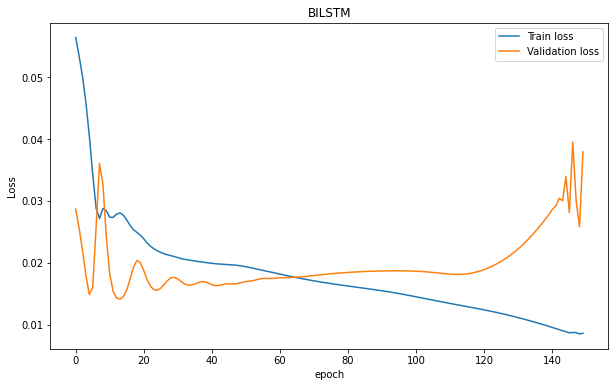

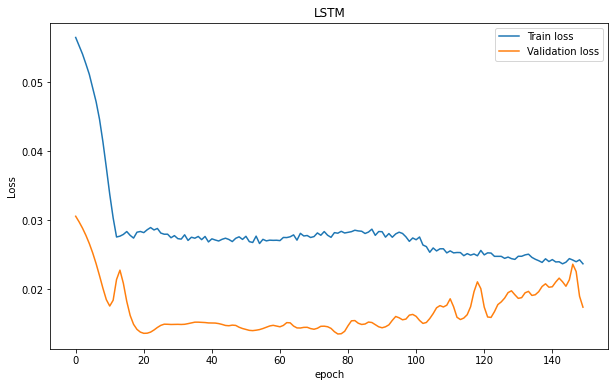

In [6]:
data = replace_missing(data)
data = resample_stock_data(data)
training_df, testing_df = train_test_split(data, 0.8)

target_brands = []
for column in data.columns:
    if "brand" in column:
        target_brands.append(column)
x_train, y_train, x_test, y_test = create_X_Y_train(training_df, testing_df, target_brands)
scaler_x, scaler_y, train_x_norm, train_y_norm, test_x_norm, test_y_norm = scale_and_transform(x_train, y_train, x_test, y_test)

TIME_STEPS = 2
x_test_3d, y_test_3d = create_dataset(test_x_norm, test_y_norm, TIME_STEPS)
x_train_3d, y_train_3d = create_dataset(train_x_norm, train_y_norm, TIME_STEPS)

model_bilstm = create_model_bilstm(128, 'huber_loss', x_train_3d, len(target_brands))
model_lstm = create_model(LSTM, 128, 'huber_loss', x_train_3d, len(target_brands))

epochs = 150

history_bilstm = fit_model(model_bilstm, epochs , x_train_3d, y_train_3d)
history_lstm = fit_model(model_lstm, epochs, x_train_3d, y_train_3d)

plot_loss (history_bilstm, 'BILSTM')
plot_loss (history_lstm, 'LSTM')


In [7]:
target_brands = []
for c in data.columns:
    if 'brand' in c:
        target_brands.append(c)

target_brands_train = [c + ' train' for c in target_brands]
target_brands_test = [c + ' test' for c in target_brands]
target_brands_actual = [c + ' actual' for c in target_brands]

In [8]:
y_train, y_test = inverse_transformation(scaler_y, y_train_3d, y_test_3d)

bilstm_fit = model_fitting(model_bilstm, x_train_3d, scaler_y)
lstm_fit = model_fitting(model_lstm, x_train_3d, scaler_y)

df_train_bilstm = pd.DataFrame(bilstm_fit, columns= target_brands_train )
df_train_lstm = pd.DataFrame(lstm_fit, columns= target_brands_train)

df_y_train = pd.DataFrame(y_train, columns = target_brands_actual)

df_concat_train_bilstm = pd.concat([df_train_bilstm, df_y_train], axis=1)
df_concat_train_lstm = pd.concat([df_train_lstm, df_y_train], axis=1)

df_concat_train_bilstm.to_csv('Stock Category Model Results\df_train_bilstm 500 epochs monthly.csv')
df_concat_train_lstm.to_csv('Stock Category Model Results\df_train_lstm 500 epochs monthly.csv')

prediction_bilstm = prediction(model_bilstm, x_test_3d, scaler_y)
prediction_lstm = prediction(model_lstm, x_test_3d, scaler_y)

df_test_bilstm = pd.DataFrame(prediction_bilstm, columns= target_brands_test )
df_test_lstm = pd.DataFrame(prediction_lstm, columns= target_brands_test)

df_y_test = pd.DataFrame(y_test, columns = target_brands_actual)


df_concat_test_bilstm = pd.concat([df_test_bilstm, df_y_test], axis=1)
df_concat_test_lstm = pd.concat([df_test_lstm, df_y_test], axis=1)
    
df_concat_test_bilstm.to_csv('Stock Category Model Results\df_test_bilstm 500 epochs monthly.csv')
df_concat_test_lstm.to_csv('Stock Category Model Results\df_test_lstm 500 epochs monthly.csv')


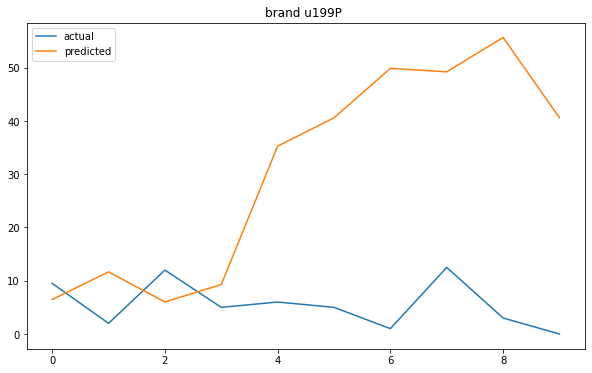

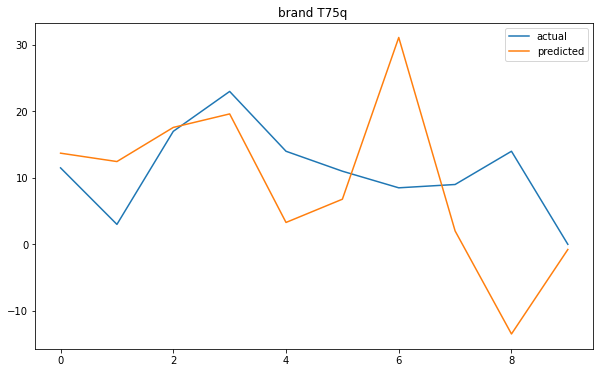

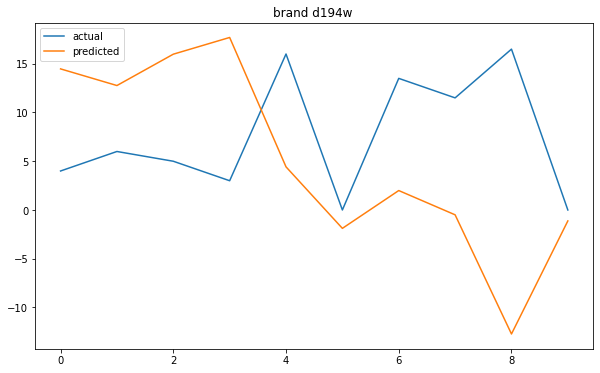

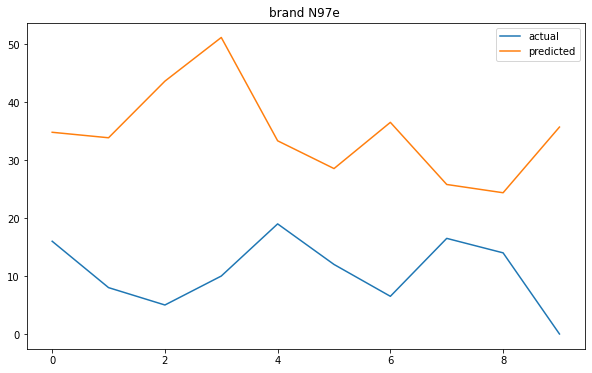

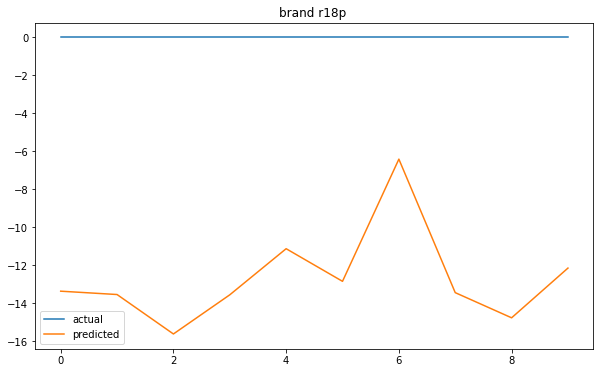

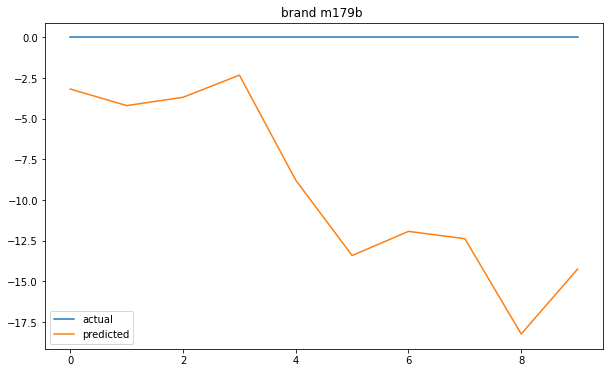

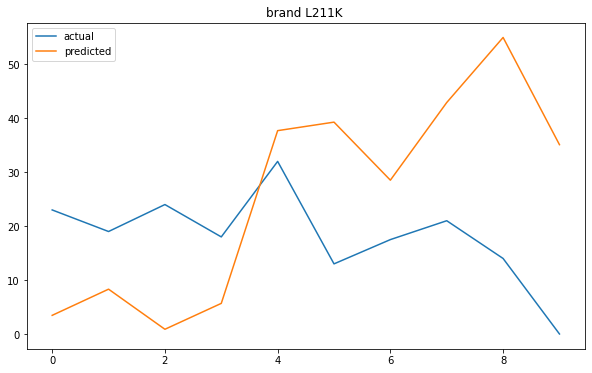

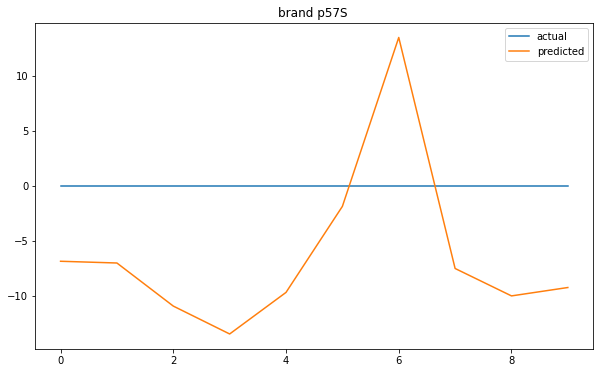

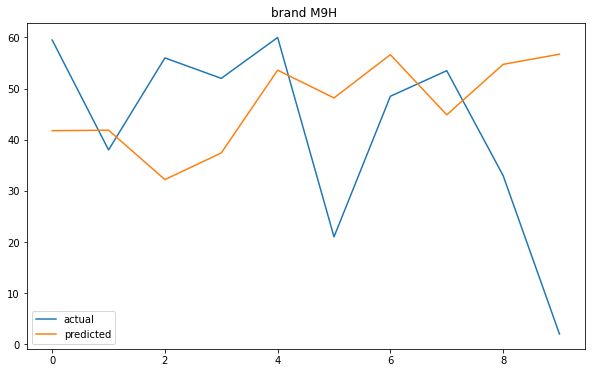

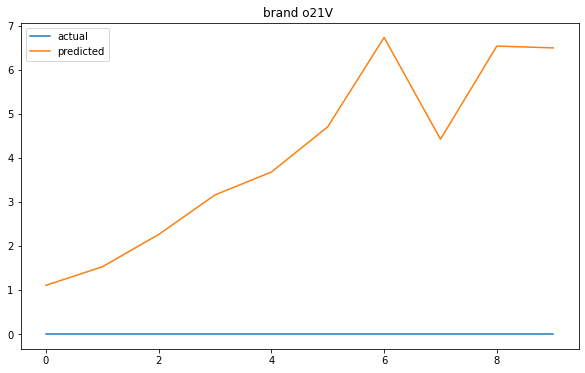

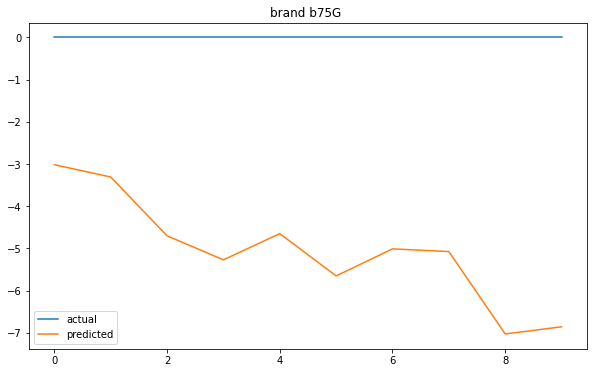

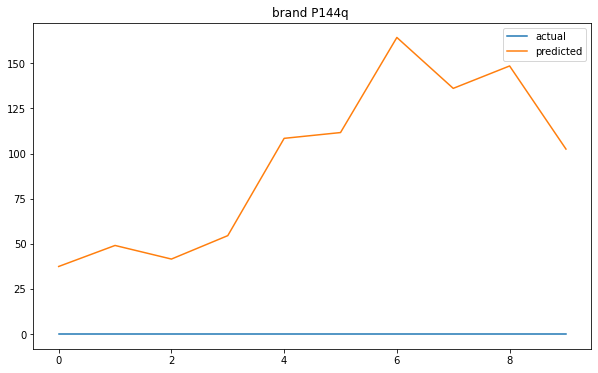

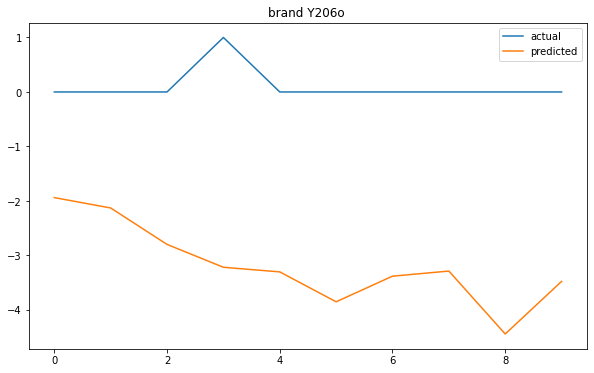

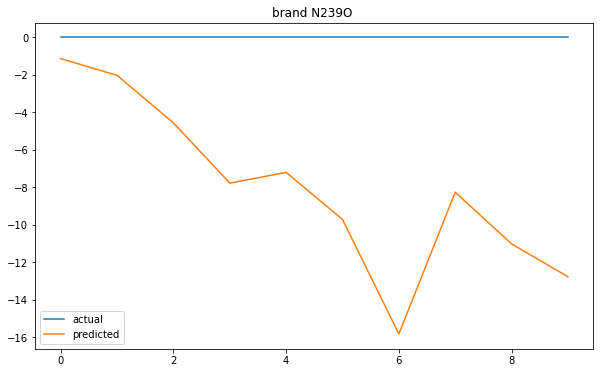

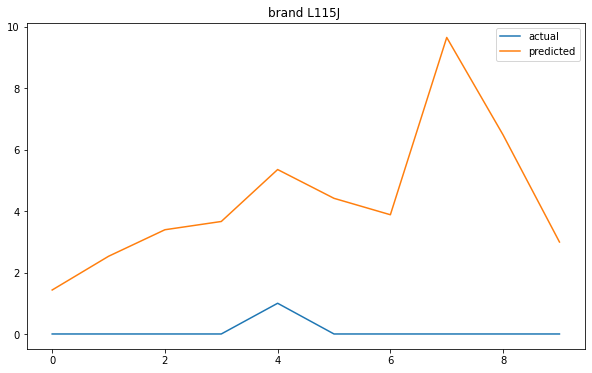

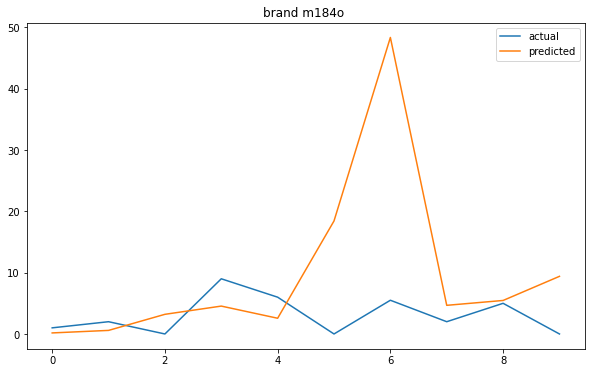

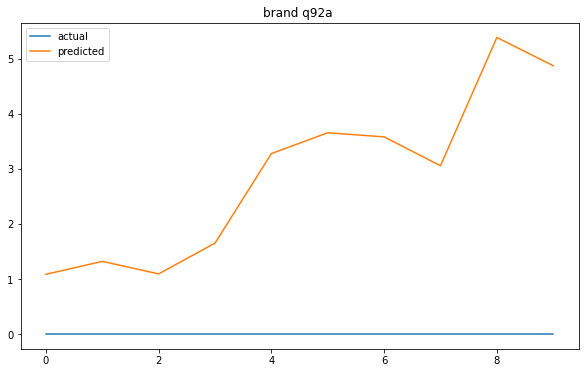

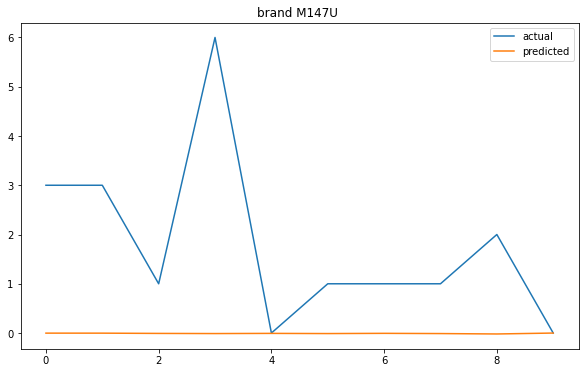

In [9]:
df_test_bilstm = pd.read_csv('Stock Category Model Results\df_test_bilstm 500 epochs monthly.csv')
df_test_bilstm.drop('Unnamed: 0', inplace=True, axis=1)
for column in df_test_bilstm.columns:
    if 'test' not in column:

        actual_values = df_test_bilstm[column].tolist()
        test_column = column.replace('actual', '') + 'test'
        test_values = df_test_bilstm[test_column].tolist()
        plt.figure(figsize=(10,6))
        plt.plot(actual_values, label = 'actual')
        plt.plot(test_values, label = 'predicted')
        title = column.replace('actual', '')
        plt.title(title)
        plt.legend()
        plt.show()
        

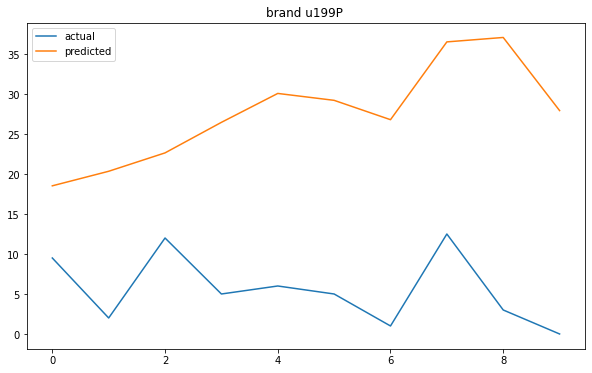

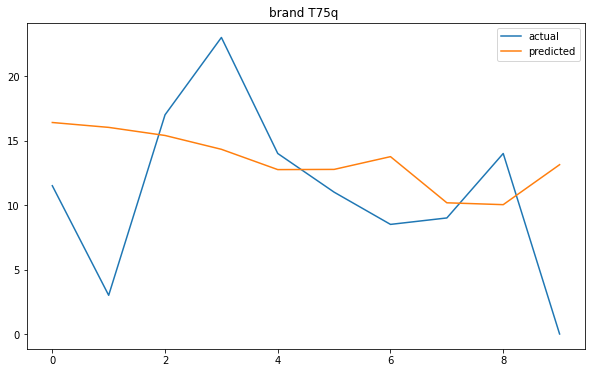

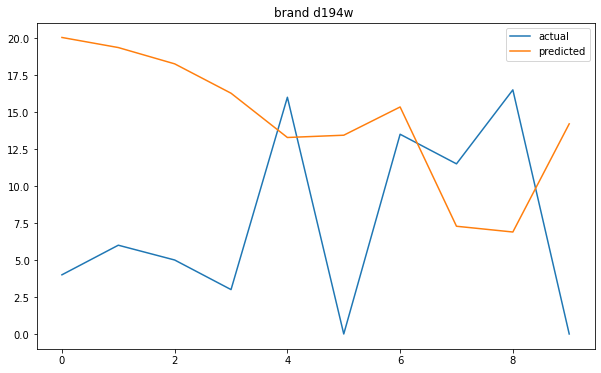

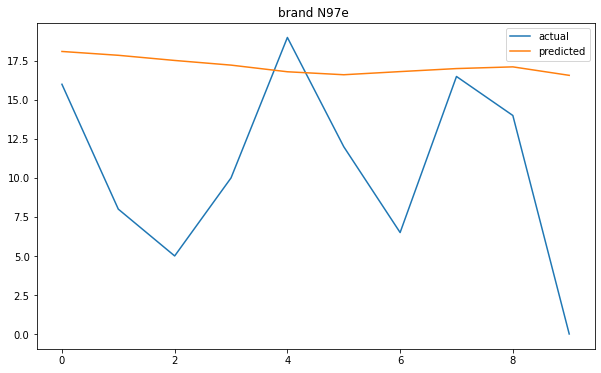

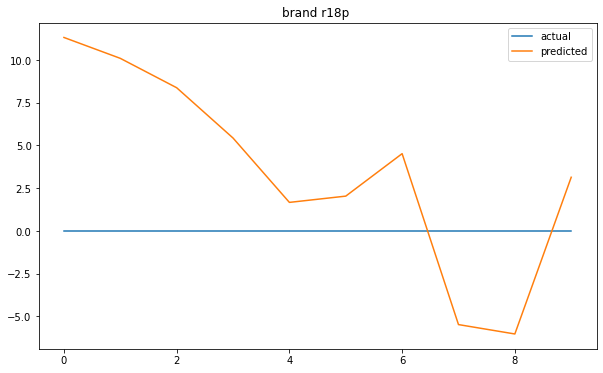

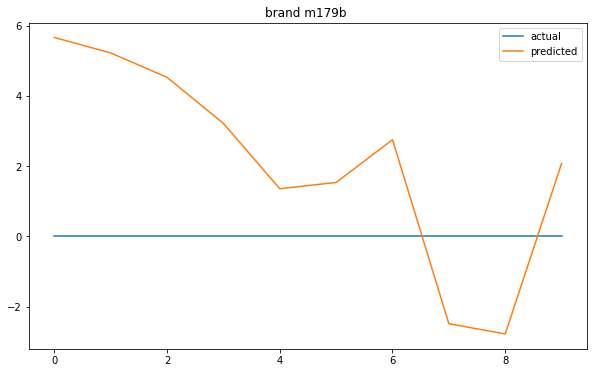

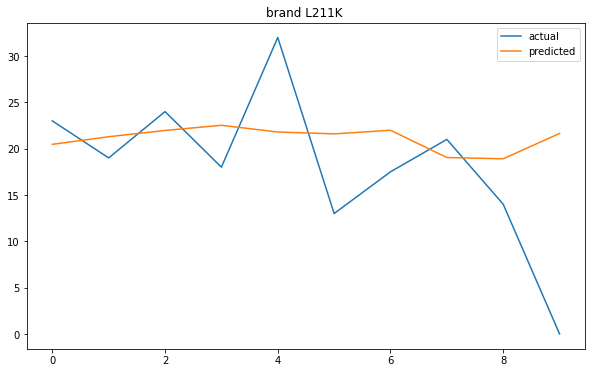

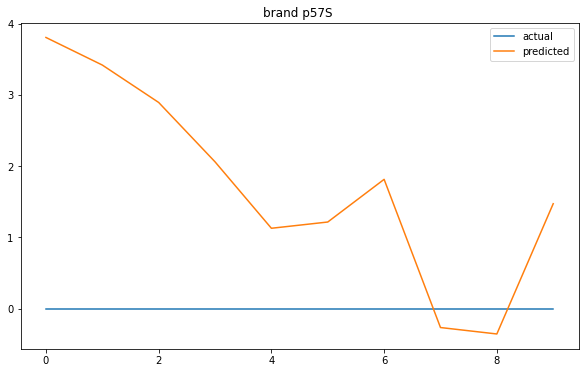

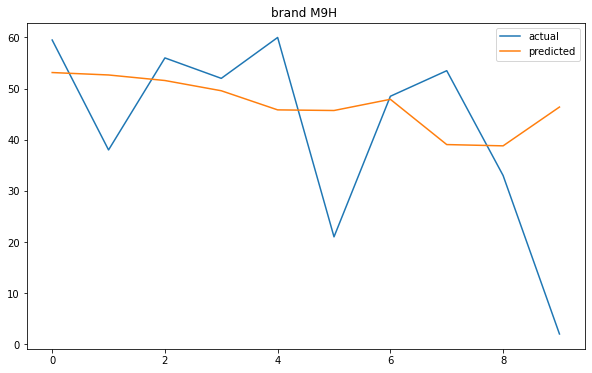

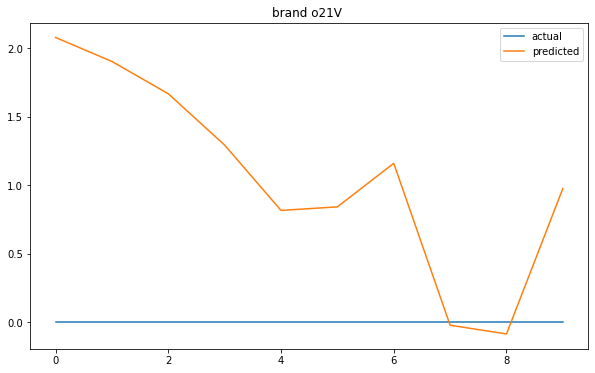

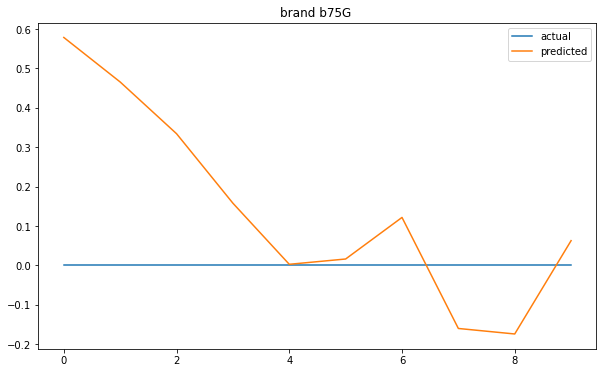

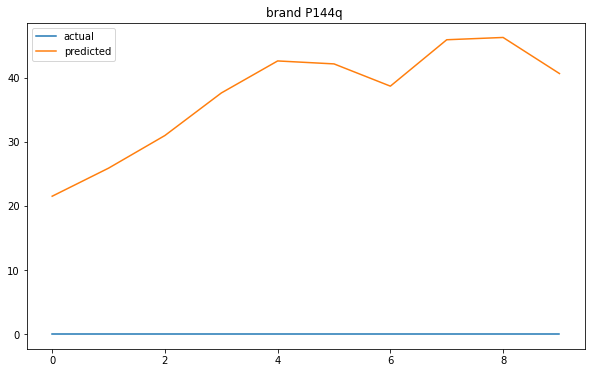

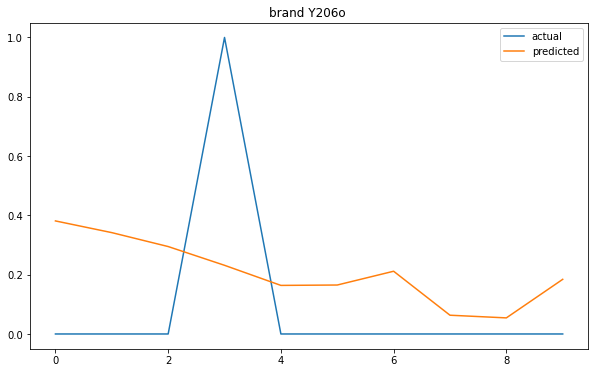

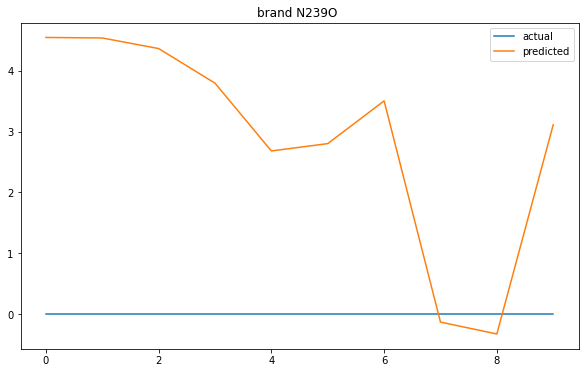

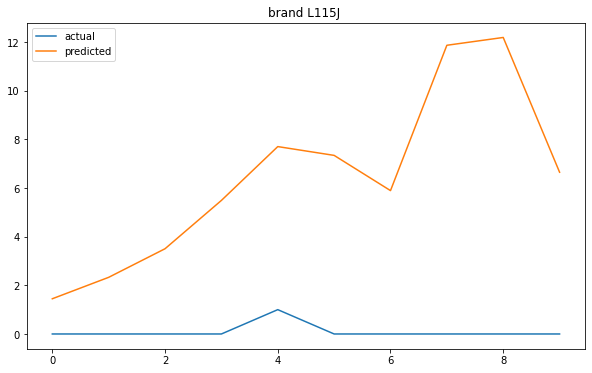

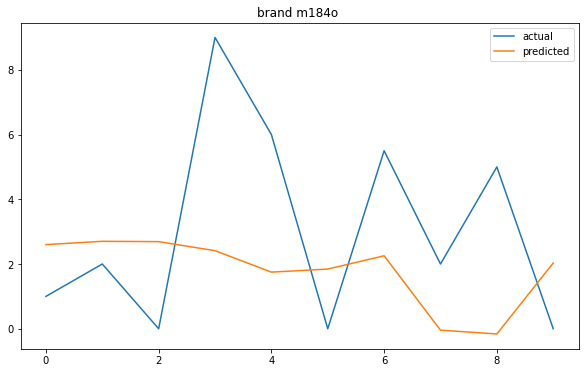

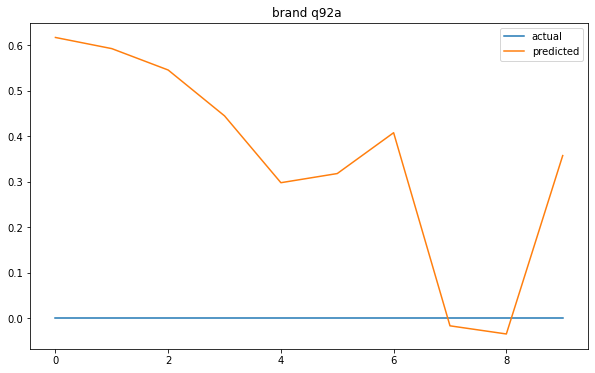

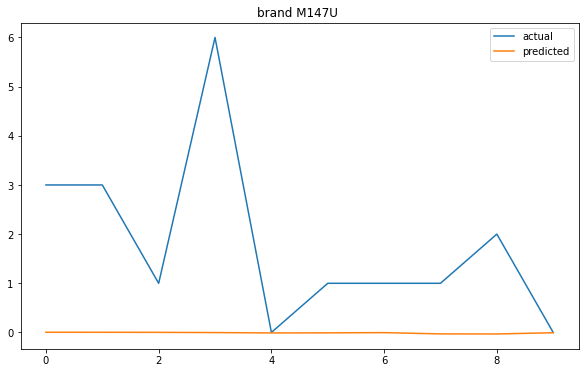

In [10]:
df_test_lstm = pd.read_csv('Stock Category Model Results\df_test_lstm 500 epochs monthly.csv')
df_test_lstm.drop('Unnamed: 0', inplace=True, axis=1)
for column in df_test_lstm.columns:
    if 'test' not in column:

        actual_values = df_test_lstm[column].tolist()
        test_column = column.replace('actual', '') + 'test'
        test_values = df_test_lstm[test_column].tolist()
        plt.figure(figsize=(10,6))
        plt.plot(actual_values, label = 'actual')
        plt.plot(test_values, label = 'predicted')
        title = column.replace('actual', '')
        plt.title(title)
        plt.legend()
        plt.show()
        